In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
!pip install openpyxl
import warnings
warnings.filterwarnings("ignore")

## Importing and handeling Data

In [11]:
file_path = "/Users/edouard/Desktop/Baruch College NY/1A/Time Series Analysis/Time-Series-Analysis/HW/HW1/Time Series Data.xlsx"
df = pd.read_excel(file_path)

In [12]:
prices = df['Unnamed: 1']
returns = np.log(prices).diff().dropna()

## Fitting Arima 1

In [13]:
ar_model = ARIMA(returns, order=(1,0,0)).fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Unnamed: 1   No. Observations:                 3771
Model:                 ARIMA(1, 0, 0)   Log Likelihood               11025.996
Date:                Thu, 04 Sep 2025   AIC                         -22045.992
Time:                        17:11:49   BIC                         -22027.287
Sample:                             0   HQIC                        -22039.342
                               - 3771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.355      0.001       0.000       0.001
ar.L1         -0.0928      0.009    -10.777      0.000      -0.110      -0.076
sigma2         0.0002   1.94e-06     86.996      0.0

## Predicting with arima 1 for the next 5 day + theorical error

In [14]:
horizons = [1,2,5]
ar_fore = ar_model.get_forecast(steps=max(horizons))
print("\nAR(1) forecasts (1,2,5):")
print(ar_fore.predicted_mean.iloc[[h-1 for h in horizons]])

phi = ar_model.arparams[0]
sigma2_ar = ar_model.scale

def var_ar1(h, phi, sigma2):
    if abs(1 - phi**2) < 1e-12:
        return sigma2 * h
    return sigma2 * (1 - phi**(2*h)) / (1 - phi**2)

print("\nAR(1) theoretical forecast error variances:")
for h in horizons:
    print(f"h={h}: {var_ar1(h, phi, sigma2_ar)}")

print("\nAR(1) empirical forecast error variances (statsmodels):")
print(ar_fore.var_pred_mean.iloc[[h-1 for h in horizons]])


AR(1) forecasts (1,2,5):
3771    0.000066
3772    0.000722
3775    0.000667
Name: predicted_mean, dtype: float64

AR(1) theoretical forecast error variances:
h=1: 1.0
h=2: 1.0086133132112551
h=5: 1.008688146894273

AR(1) empirical forecast error variances (statsmodels):
3771    0.000169
3772    0.000170
3775    0.000170
Name: var_pred_mean, dtype: float64


## Fitting + Predicting + Error with MA(1)

In [15]:
ma_model = ARIMA(returns, order=(0,0,1)).fit()
print(ma_model.summary())

ma_fore = ma_model.get_forecast(steps=max(horizons))
print("\nMA(1) forecasts (1,2,5):")
print(ma_fore.predicted_mean.iloc[[h-1 for h in horizons]])

theta = ma_model.maparams[0]
sigma2_ma = ma_model.scale

def var_ma1(h, theta, sigma2):
    return sigma2 if h == 1 else sigma2 * (1 + theta**2)

print("\nMA(1) theoretical forecast error variances:")
for h in horizons:
    print(f"h={h}: {var_ma1(h, theta, sigma2_ma)}")

print("\nMA(1) empirical forecast error variances (statsmodels):")
print(ma_fore.var_pred_mean.iloc[[h-1 for h in horizons]])

                               SARIMAX Results                                
Dep. Variable:             Unnamed: 1   No. Observations:                 3771
Model:                 ARIMA(0, 0, 1)   Log Likelihood               11025.023
Date:                Thu, 04 Sep 2025   AIC                         -22044.046
Time:                        17:11:49   BIC                         -22025.340
Sample:                             0   HQIC                        -22037.395
                               - 3771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.332      0.001       0.000       0.001
ma.L1         -0.0885      0.009     -9.707      0.000      -0.106      -0.071
sigma2         0.0002   1.93e-06     87.580      0.0

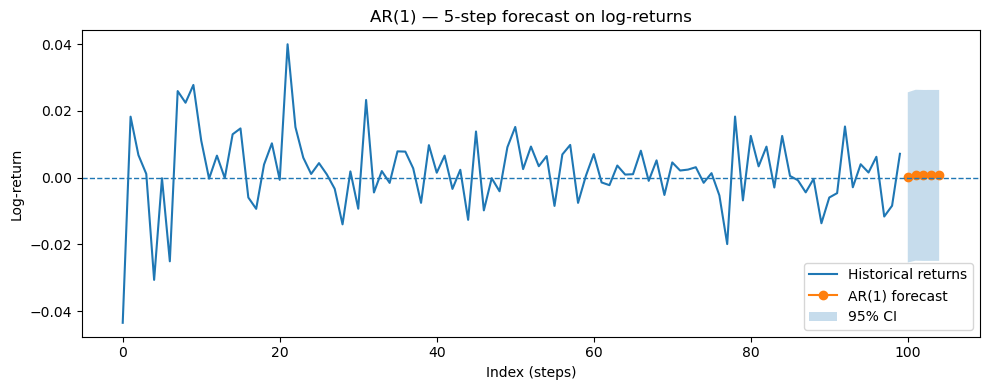

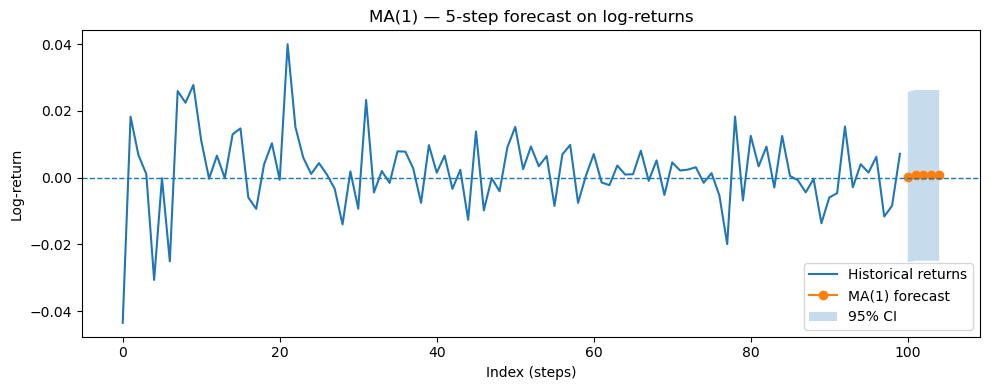

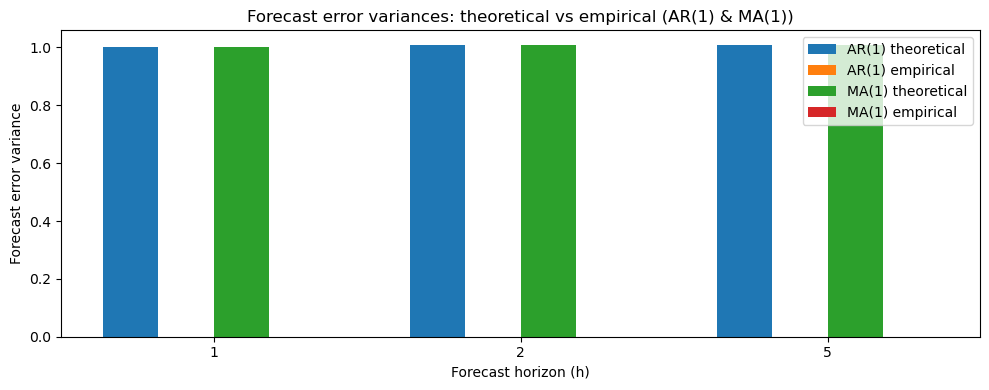

In [16]:
import matplotlib.pyplot as plt
import numpy as np

ar_steps = max(horizons)
ar_pred = ar_fore.predicted_mean
ar_ci = ar_fore.conf_int(alpha=0.05)
ar_lower = ar_ci.iloc[:, 0]
ar_upper = ar_ci.iloc[:, 1]

hist_n = 100
hist_vals = returns.iloc[-hist_n:] if len(returns) > hist_n else returns

fig = plt.figure(figsize=(10, 4))
plt.plot(range(len(hist_vals)), hist_vals.values, label="Historical returns")
future_x = np.arange(len(hist_vals), len(hist_vals) + ar_steps)
plt.plot(future_x, ar_pred.values, marker="o", label="AR(1) forecast")
plt.fill_between(future_x, ar_lower.values, ar_upper.values, alpha=0.25, label="95% CI")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("AR(1) — 5-step forecast on log-returns")
plt.xlabel("Index (steps)")
plt.ylabel("Log-return")
plt.legend()
plt.tight_layout()
plt.show()

ma_steps = max(horizons)
ma_pred = ma_fore.predicted_mean
ma_ci = ma_fore.conf_int(alpha=0.05)
ma_lower = ma_ci.iloc[:, 0]
ma_upper = ma_ci.iloc[:, 1]

fig = plt.figure(figsize=(10, 4))
plt.plot(range(len(hist_vals)), hist_vals.values, label="Historical returns")
future_x = np.arange(len(hist_vals), len(hist_vals) + ma_steps)
plt.plot(future_x, ma_pred.values, marker="o", label="MA(1) forecast")
plt.fill_between(future_x, ma_lower.values, ma_upper.values, alpha=0.25, label="95% CI")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("MA(1) — 5-step forecast on log-returns")
plt.xlabel("Index (steps)")
plt.ylabel("Log-return")
plt.legend()
plt.tight_layout()
plt.show()

ar_theo = [var_ar1(h, phi, sigma2_ar) for h in horizons]
ar_emp = ar_fore.var_pred_mean.iloc[[h-1 for h in horizons]].values

ma_theo = [var_ma1(h, theta, sigma2_ma) for h in horizons]
ma_emp = ma_fore.var_pred_mean.iloc[[h-1 for h in horizons]].values

fig = plt.figure(figsize=(10, 4))
x = np.arange(len(horizons))
width = 0.18

plt.bar(x - 1.5*width, ar_theo, width=width, label="AR(1) theoretical")
plt.bar(x - 0.5*width, ar_emp, width=width, label="AR(1) empirical")
plt.bar(x + 0.5*width, ma_theo, width=width, label="MA(1) theoretical")
plt.bar(x + 1.5*width, ma_emp, width=width, label="MA(1) empirical")

plt.xticks(x, horizons)
plt.xlabel("Forecast horizon (h)")
plt.ylabel("Forecast error variance")
plt.title("Forecast error variances: theoretical vs empirical (AR(1) & MA(1))")
plt.legend()
plt.tight_layout()
plt.show()


Thus the variance increases using AR(1) for longer forcast, which implies that the risk increases. It is not the case for MA(1), as the price in this caase only depends on the past 2 noises and not the stock price. We give more details in the following.

### (iii)

- **AR(1):**
  - Forecasts gradually decay toward the unconditional mean.
  - Each additional horizon adds more uncertainty, since past shocks keep influencing the process through the autoregressive term.
  - Forecast error variance **increases with horizon**:
    $$
    Var(e_{t+h}) = \sigma^2 \sum_{j=0}^{h-1} \phi^{2j}, \quad \uparrow h
    $$

- **MA(1):**
  - Forecasts converge to the mean much more quickly, since the model only depends on the most recent shocks.
  - Forecast error variance rises from $\sigma^2$ at $h=1$ to $\sigma^2(1+\theta^2)$ at $h=2$, but then stays **constant** for all $h \geq 2$.
  - This reflects the **short memory** nature of MA processes.


### (iv

- **Short horizon forecasts are more reliable**:
  - In AR models, information from recent returns helps improve 1-step or 2-step forecasts before uncertainty accumulates.
  - In MA models, beyond one or two steps, forecasts quickly revert to the unconditional mean and provide little new information.

- **Long horizon forecasts are less useful**:
  - For AR(1), the forecast error variance grows steadily with horizon, making predictions increasingly uncertain.
  - For MA(1), although variance stabilizes, the forecast itself quickly converges to the mean, so forecasts add no predictive power beyond "average return."

- **Implications for portfolio risk management**:
  - **Short-term risk management (1–2 days ahead):** AR/MA forecasts may provide useful signals about expected returns or risk (but really small).
  - **Long-term horizons:** Forecasts are essentially uninformative; risk assessment should rely more on volatility models (e.g., GARCH, stochastic volatility) rather than AR/MA dynamics.
  - This explains why financial institutions typically **trust short-horizon forecasts** for trading and hedging, while long-term portfolio management depends more on diversification and proper portofolio construction via factor analysis.


We gave the $R^2$ scores in the last cells that are of course negative as the signal is now completly arbitraged away. 

In [17]:
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

returns = np.log(prices).diff().dropna()

split_ratio = 0.8
split_idx = int(len(returns) * split_ratio)

train = returns.iloc[:split_idx]
test = returns.iloc[split_idx:]

ar_model = ARIMA(train, order=(1,0,0)).fit()
ar_forecast = ar_model.get_forecast(steps=len(test))
ar_pred = ar_forecast.predicted_mean

ma_model = ARIMA(train, order=(0,0,1)).fit()
ma_forecast = ma_model.get_forecast(steps=len(test))
ma_pred = ma_forecast.predicted_mean

r2_ar = r2_score(test, ar_pred)
r2_ma = r2_score(test, ma_pred)

print(f"R² (AR(1)): {r2_ar:.4f}")
print(f"R² (MA(1)): {r2_ma:.4f}")


R² (AR(1)): -0.0004
R² (MA(1)): -0.0005


Finally, because $R^2$ is not a really good lmetric, we give the spearman correlation, which is much more robust. We see that the AR model outperforms the MA models, which actually give very bad results. However, the coefficients are very small and not statistically significant (p-values >> 0.05). 



This means that neither AR(1) nor MA(1) provides meaningful predictive power 
for daily log-returns.

In [18]:
from scipy.stats import spearmanr

# === Spearman correlations ===
rho_ar, pval_ar = spearmanr(test, ar_pred)
rho_ma, pval_ma = spearmanr(test, ma_pred)

print(f"Spearman correlation (AR(1)): {rho_ar:.4f}   (p-value={pval_ar:.4f})")
print(f"Spearman correlation (MA(1)): {rho_ma:.4f}   (p-value={pval_ma:.4f})")


Spearman correlation (AR(1)): 0.0140   (p-value=0.6999)
Spearman correlation (MA(1)): -0.0438   (p-value=0.2296)
